In [69]:
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
   

In [70]:
import logging

import matplotlib.pyplot as plt
from numpy.random import RandomState

from sklearn import cluster, decomposition
from sklearn.datasets import fetch_olivetti_faces

rng = RandomState(0)

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format="%(asctime)s %(levelname)s %(message)s")

faces, _ = fetch_olivetti_faces(data_home="/mnt/ML Summer Learning/Paper_Implementation-master/Paper_Implementation-master/t-SNE/data", return_X_y=True, shuffle=True, random_state=rng)
n_samples, n_features = faces.shape

# Global centering (focus on one feature, centering all samples)
faces_centered = faces - faces.mean(axis=0)

# Local centering (focus on one sample, centering all features)
faces_centered -= faces_centered.mean(axis=1).reshape(n_samples, -1)

print("Dataset consists of %d faces" % n_samples)

Dataset consists of 400 faces


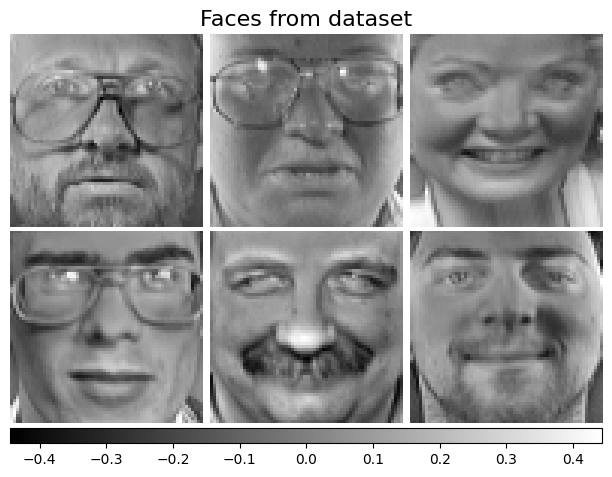

In [71]:
n_row, n_col = 2, 3
n_components = n_row * n_col
image_shape = (64, 64)


def plot_gallery(title, images, n_col=n_col, n_row=n_row, cmap=plt.cm.gray):
    fig, axs = plt.subplots(
        nrows=n_row,
        ncols=n_col,
        figsize=(2.0 * n_col, 2.3 * n_row),
        facecolor="white",
        constrained_layout=True,
    )
    fig.set_constrained_layout_pads(w_pad=0.01, h_pad=0.02, hspace=0, wspace=0)
    fig.set_edgecolor("black")
    fig.suptitle(title, size=16)
    for ax, vec in zip(axs.flat, images):
        vmax = max(vec.max(), -vec.min())
        im = ax.imshow(
            vec.reshape(image_shape),
            cmap=cmap,
            interpolation="nearest",
            vmin=-vmax,
            vmax=vmax,
        )
        ax.axis("off")

    fig.colorbar(im, ax=axs, orientation="horizontal", shrink=0.99, aspect=40, pad=0.01)
    plt.show()

plot_gallery("Faces from dataset", faces_centered[:n_components])

## PCA

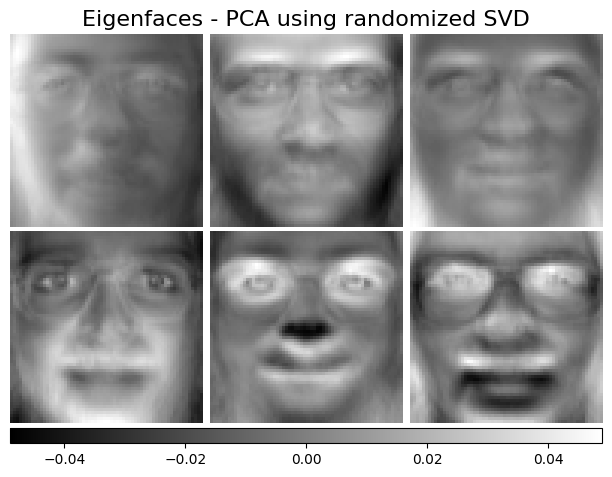

In [72]:
pca_estimator = decomposition.PCA(
    n_components=n_components, svd_solver="randomized", whiten=True
)
pca_estimator.fit(faces_centered)
plot_gallery(
    "Eigenfaces - PCA using randomized SVD", pca_estimator.components_[:n_components]
)

## t-SNE

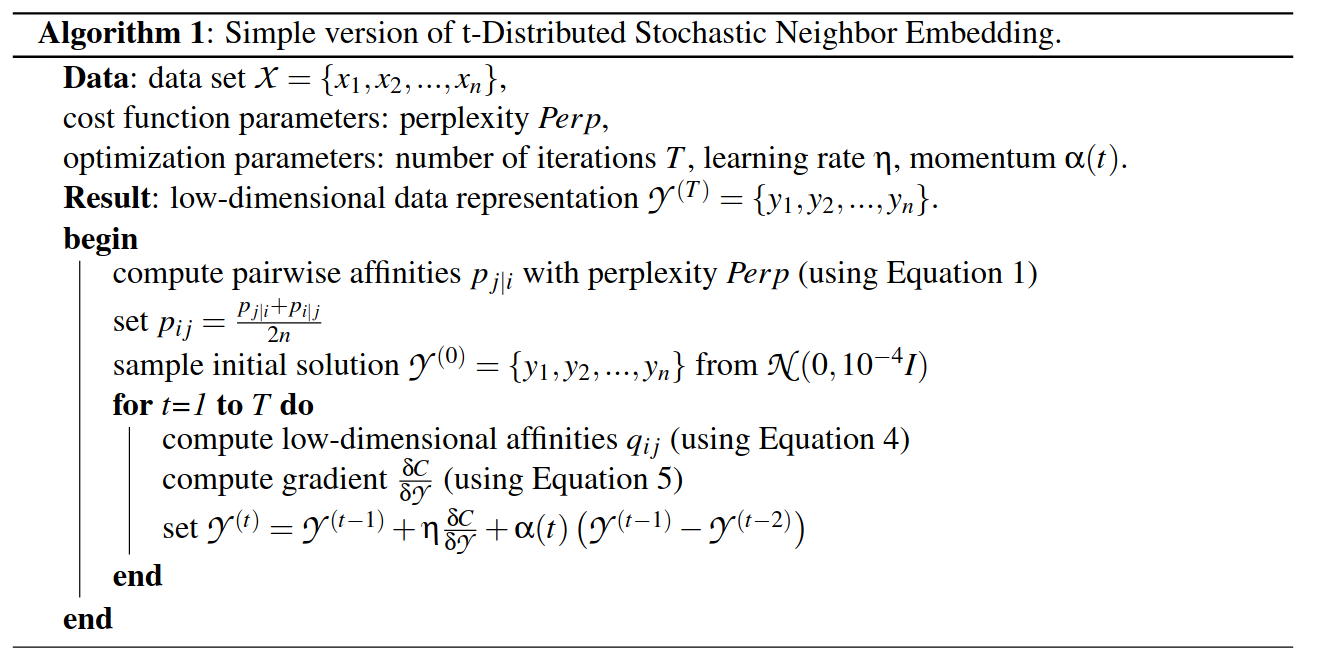

In [85]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from tensorflow.keras.datasets import mnist

# Load data
(X_train, y_train), (_, _) = mnist.load_data()
X_train = X_train.reshape(-1, 28*28)

# Build small balanced subset: 10 samples per class
X_small, y_small = [], []
for digit in range(10):
    idx = np.where(y_train == digit)[0][:20]  # first 10 indices of this class
    X_small.append(X_train[idx])
    y_small.append(y_train[idx])

# Stack into arrays
X_small = np.vstack(X_small)
y_small = np.hstack(y_small)
X = PCA(n_components=30).fit_transform(X_small)
y = y_small

print("Dataset shape:", X_small.shape, y_small.shape)


Dataset shape: (200, 784) (200,)


In [90]:
def grid_search(diff_i: np.ndarray, i: int, perplexity: int) -> float:
    """
    Helper function to obtain σ's based on user-specified perplexity.

    Parameters:
        diff_i (np.ndarray): Array containing the pairwise differences between data points.
        i (int): Index of the current data point.
        perplexity (int): User-specified perplexity value.

    Returns:
        float: The value of σ that satisfies the perplexity condition.
    """

    result = np.inf  # Set first result to be infinity

    norm = np.linalg.norm(diff_i, axis=1)
    std_norm = np.std(norm)  # Use standard deviation of norms to define search space

    for σ_search in np.linspace(0.01 * std_norm, 5 * std_norm, 200):
        # Equation 1 Numerator
        p = np.exp(-(norm**2) / (2 * σ_search**2))

        # Set p = 0 when i = j
        p[i] = 0

        # Equation 1 (ε -> 0)
        ε = np.nextafter(0, 1)
        p_new = np.maximum(p / np.sum(p), ε)

        # Shannon Entropy
        H = -np.sum(p_new * np.log2(p_new))

        # Get log(perplexity equation) as close to equality
        if np.abs(np.log(perplexity) - H * np.log(2)) < np.abs(result):
            result = np.log(perplexity) - H * np.log(2)
            σ = σ_search

    return σ

def get_original_pairwise_affinities(X, perplexity=10):
    
    n = len(X)
    p_ij = np.zeros((n, n))

    for i in range(n):
        diff = X[i] - X
        σ_i = grid_search(diff, i, perplexity)
        norm = np.linalg.norm(diff, axis=1)

        # Equation 1 Numerator
        p_ij[i,:] = np.exp(-(norm**2) / (2 * σ_i**2))
        np.fill_diagonal(p_ij, 0)  # Set p = 0 when i = j
        p_ij[i,:] = p_ij[i,:] / np.sum(p_ij[i,:])  # Equation 1 (ε -> 0)

    # Symmetrize p_ij
    ε = np.nextafter(0, 1)
    p_ij = np.maximum(p_ij, ε)

    return p_ij

def get_symmetric_p_ij(p_ij: np.ndarray) -> np.ndarray:
    """
    Function to obtain symmetric affinities matrix utilized in t-SNE.

    Parameters:
    p_ij (np.ndarray): The input affinity matrix.

    Returns:
    np.ndarray: The symmetric affinities matrix.

    """
    # print("Computing Symmetric p_ij matrix....")

    n = len(p_ij)
    p_ij_symmetric = np.zeros(shape=(n, n))
    for i in range(0, n):
        for j in range(0, n):
            p_ij_symmetric[i, j] = (p_ij[i, j] + p_ij[j, i]) / (2 * n)

    # Set 0 values to minimum numpy value (ε approx. = 0)
    ε = np.nextafter(0, 1)
    p_ij_symmetric = np.maximum(p_ij_symmetric, ε)

    # print("Completed Symmetric p_ij Matrix.")

    return p_ij_symmetric


def initialization(
    X: np.ndarray, n_dimensions: int = 2, initialization: str = "random"
) -> np.ndarray:
    """
    Obtain initial solution for t-SNE either randomly or using PCA.

    Parameters:
        X (np.ndarray): The input data array.
        n_dimensions (int): The number of dimensions for the output solution. Default is 2.
        initialization (str): The initialization method. Can be 'random' or 'PCA'. Default is 'random'.

    Returns:
        np.ndarray: The initial solution for t-SNE.

    Raises:
        ValueError: If the initialization method is neither 'random' nor 'PCA'.
    """

    # Sample Initial Solution
    if initialization == "random" or initialization != "PCA":
        y0 = np.random.normal(loc=0, scale=1e-4, size=(len(X), n_dimensions))
    elif initialization == "PCA":
        X_centered = X - X.mean(axis=0)
        _, _, Vt = np.linalg.svd(X_centered)
        y0 = X_centered @ Vt.T[:, :n_dimensions]
    else:
        raise ValueError("Initialization must be 'random' or 'PCA'")

    return y0

def get_low_dimensional_affinities(Y: np.ndarray) -> np.ndarray:
    """
    Function to compute low-dimensional affinities matrix utilized in t-SNE.

    Parameters:
        Y (np.ndarray): The low-dimensional representation of the data points.

    Returns:
        np.ndarray: The low-dimensional affinities matrix.
    """

    # print("Computing Low-Dimensional Affinities Matrix....")

    n = len(Y)
    q_ij = np.zeros(shape=(n, n))

    for i in range(n):
        diff = Y[i] - Y
        norm = np.linalg.norm(diff, axis=1)
        q_ij[i, :] = (1 + norm**2) ** (-1)

    np.fill_diagonal(q_ij, 0)

    q_ij = q_ij/ q_ij.sum()
    ε = np.nextafter(0, 1)
    q_ij = np.maximum(q_ij, ε)

    return q_ij


def get_gradient(p_ij: np.ndarray, q_ij: np.ndarray, Y: np.ndarray) -> np.ndarray:
    n = len(p_ij)

    # Compute gradient
    gradient = np.zeros(shape=(n, Y.shape[1]))
    
    for i in range(0, n):
        diff = Y[i] - Y
        A = np.array([(p_ij[i,:] - q_ij[i,:])])
        B = np.array( [ ( 1 + np.linalg.norm(diff, axis=1)**2 ) ** (-1) ])
        C = diff
        gradient[i] = 4 * np.sum((A * B).T * C, axis=0)

    return gradient

In [91]:
def tsne(
    X: np.ndarray,
    perplexity: int = 10,
    T: int = 1000,
    η: int = 200,
    early_exaggeration: int = 4,
    n_dimensions: int = 2,
) -> list[np.ndarray, np.ndarray]:
    """
    t-SNE (t-Distributed Stochastic Neighbor Embedding) algorithm implementation.

    Args:
        X (np.ndarray): The input data matrix of shape (n_samples, n_features).
        perplexity (int, optional): The perplexity parameter. Default is 10.
        T (int, optional): The number of iterations for optimization. Default is 1000.
        η (int, optional): The learning rate for updating the low-dimensional embeddings. Default is 200.
        early_exaggeration (int, optional): The factor by which the pairwise affinities are exaggerated
            during the early iterations of optimization. Default is 4.
        n_dimensions (int, optional): The number of dimensions of the low-dimensional embeddings. Default is 2.

    Returns:
        list[np.ndarray, np.ndarray]: A list containing the final low-dimensional embeddings and the history
            of embeddings at each iteration.

    """
    n = len(X)

    # Get original affinities matrix
    p_ij = get_original_pairwise_affinities(X, perplexity)
    p_ij_symmetric = get_symmetric_p_ij(p_ij)

    # Initialization
    Y = np.zeros(shape=(T, n, n_dimensions))
    Y_minus1 = np.zeros(shape=(n, n_dimensions))
    Y[0] = Y_minus1
    Y1 = initialization(X, n_dimensions)
    Y[1] = np.array(Y1)

    print("Optimizing Low Dimensional Embedding....")
    # Optimization
    for t in range(1, T - 1):
        # Momentum &amp; Early Exaggeration
        if t < 250:
            α = 0.5
            early_exaggeration = early_exaggeration
        else:
            α = 0.8
            early_exaggeration = 1

        # Get Low Dimensional Affinities
        q_ij = get_low_dimensional_affinities(Y[t])

        # Get Gradient of Cost Function
        gradient = get_gradient(early_exaggeration * p_ij_symmetric, q_ij, Y[t])

        # Update Rule
        Y[t + 1] = Y[t] - η * gradient + α * (Y[t] - Y[t - 1])  # Use negative gradient

        # Compute current value of cost function
        if t % 50 == 0 or t == 1:
            cost = np.sum(p_ij_symmetric * np.log(p_ij_symmetric / q_ij))
            print(f"Iteration {t}: Value of Cost Function is {cost}")

    print(
        f"Completed Low Dimensional Embedding: Final Value of Cost Function is {np.sum(p_ij_symmetric * np.log(p_ij_symmetric / q_ij))}"
    )
    solution = Y[-1]

    return solution, Y

In [92]:
sol, Y = tsne(X)

Optimizing Low Dimensional Embedding....
Iteration 1: Value of Cost Function is 2.8572452461858426
Iteration 50: Value of Cost Function is 2.605099044261214
Iteration 100: Value of Cost Function is 2.227044458063611
Iteration 150: Value of Cost Function is 2.1418837142139675
Iteration 200: Value of Cost Function is 2.08512419846847
Iteration 250: Value of Cost Function is 2.2778036675518356
Iteration 300: Value of Cost Function is 0.6141708129815157
Iteration 350: Value of Cost Function is 0.5109170506524378
Iteration 400: Value of Cost Function is 0.5030400402867701
Iteration 450: Value of Cost Function is 0.4991097410341422
Iteration 500: Value of Cost Function is 0.49644418337530677
Iteration 550: Value of Cost Function is 0.49430000883102077
Iteration 600: Value of Cost Function is 0.4921970945173024
Iteration 650: Value of Cost Function is 0.4896056301963938
Iteration 700: Value of Cost Function is 0.48824742007890815
Iteration 750: Value of Cost Function is 0.4873230400338875
Ite

In [93]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=3).fit_transform(X)

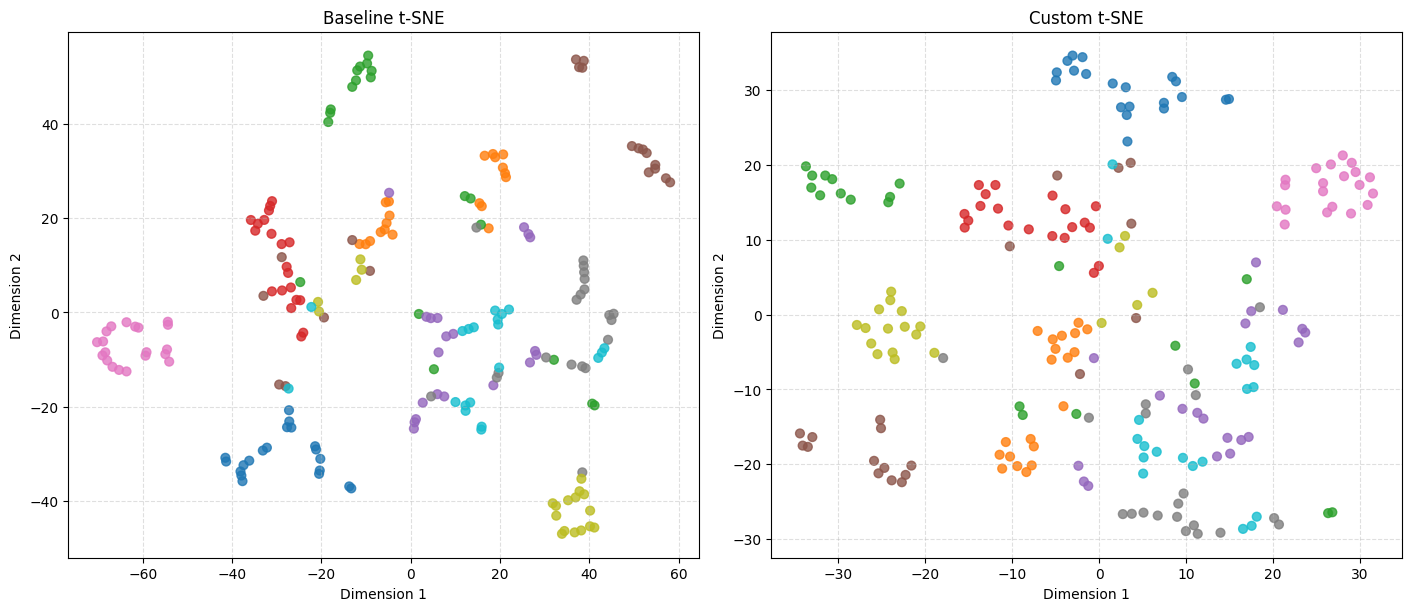

In [94]:
import matplotlib.pyplot as plt
import numpy as np

def plot_tsne_comparison(Y1, Y2, y, titles=("Baseline t-SNE", "Custom t-SNE")):
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), constrained_layout=True)
    for ax, Y, title in zip(axes, [Y1, Y2], titles):
        scatter = ax.scatter(Y[:, 0], Y[:, 1], c=y, cmap='tab10', s=40, alpha=0.8)
        ax.set_title(title)
        ax.set_xlabel("Dimension 1")
        ax.set_ylabel("Dimension 2")
        ax.grid(True, linestyle='--', alpha=0.4)
    
    # Create separate axis for the colorbar (right side)
    # cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height
    # cbar_ax = fig.add_axes([0.47, 0.15, 0.02, 0.7])

    # cbar = fig.colorbar(scatter, cax=cbar_ax, ticks=range(10))
    # cbar.set_label('Digit class')

    plt.show()


plot_tsne_comparison(X_embedded, sol, y)